In [1]:
#Chuan Liew
#a1676472

#Import libraries
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow import keras

In [2]:
#Function to unpickle files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
#Unpickle batches
batch_1 = unpickle('data_batch_1')
batch_2 = unpickle('data_batch_2')
batch_3 = unpickle('data_batch_3')
batch_4 = unpickle('data_batch_4')
batch_5 = unpickle('data_batch_5')
test_batch = unpickle('test_batch')

In [4]:
#Reshape features and set labels
features_1 = batch_1[b'data'].reshape((len(batch_1[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)
labels_1 = batch_1[b'labels']
features_2 = batch_2[b'data'].reshape((len(batch_2[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)
labels_2 = batch_2[b'labels']
features_3 = batch_3[b'data'].reshape((len(batch_3[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)
labels_3 = batch_3[b'labels']
features_4 = batch_4[b'data'].reshape((len(batch_4[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)
labels_4 = batch_4[b'labels']
features_5 = batch_5[b'data'].reshape((len(batch_5[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)
labels_5 = batch_5[b'labels']
test_features = test_batch[b'data'].reshape((len(test_batch[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)
test_labels = test_batch[b'labels']

In [5]:
#Label names
label_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

Batch number: 1
Image number: 9
Label number: 3
Label name: cat


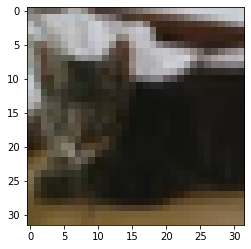

In [6]:
#Inspect an example
plt.imshow(features_1[9,:,:])
print('Batch number: 1')
print('Image number: 9')
print('Label number: %i' % labels_1[9])
print('Label name: ' + label_names[labels_1[9]])

In [7]:
#Concatenate batches
features = np.concatenate([features_1, features_2, features_3, features_4, features_5])
labels = np.concatenate([labels_1, labels_2, labels_3, labels_4, labels_5])

In [8]:
#Normalise
features = features/np.max(features)
test_features = test_features/np.max(test_features)
np.max(features)

1.0

In [9]:
#Split training and validation sets with 10% for validation
X_val, X_train = features[:5000], features[5000:]
y_val, y_train = labels[:5000], labels[5000:]
X_test, y_test = np.array(test_features), np.array(test_labels)

In [10]:
#Hyper parameters
batch_size = 50
n_epochs = 25
hiddensizes = [32, 64, 32]
learningrate = 0.1

#Activation function and optimizer
actfn = "relu"
optimizer = keras.optimizers.Adam

#Number of training and validation to use
n_train = 45000
n_val = 5000

#Early stopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 

In [11]:
#Build CNN
def model_cnn(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    #1st Convolutional layer
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                      input_shape=[32, 32, 3]))    #input layer goes into this 2D convolution
    #MaxPooling layer (downsize)
    model.add(keras.layers.MaxPooling2D(pool_size=2))          
    #2nd Convolutional layer
    model.add(keras.layers.Conv2D(filters=hiddensizes[1], kernel_size=3, strides=1, padding="same", activation=actfn))
    #MaxPooling layer
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    #3rd Convolutional layer
    model.add(keras.layers.Conv2D(filters=hiddensizes[2], kernel_size=3, strides=1, padding="same", activation=actfn))
    #MaxPooling layer
    model.add(keras.layers.MaxPooling2D(pool_size=1))
    #4th Convolutional layer
    model.add(keras.layers.Conv2D(filters=hiddensizes[2], kernel_size=3, strides=1, padding="same", activation=actfn))
    #MaxPooling layer
    model.add(keras.layers.MaxPooling2D(pool_size=1))
    #Final Convolutional layer
    model.add(keras.layers.Conv2D(filters=hiddensizes[1], kernel_size=3, strides=1, padding="same", activation=actfn))  
    #Fully connected input layer (flatten)
    model.add(keras.layers.Flatten())                       #turn outputs into a 1D vector
    #Dropout layer
    model.add(keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None))
    #Dense output layer
    model.add(keras.layers.Dense(10, activation="softmax")) #10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])   
    return model

In [12]:
#Run the model
model = model_cnn(hiddensizes, actfn, optimizer, learningrate)

In [13]:
#Fit and evaluate the model
def fit_evaluate(model, n_train, n_val, n_epochs, batch_size, further_callbacks=[]):
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = [early_stopping_cb] + further_callbacks,
                        validation_data=(X_val[:n_val,:,:,:], y_val[:n_val]),verbose=1)
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model.evaluate(X_test, y_test, verbose=0)
    return (max_val_acc, testres[1], history, model)

val_acc, test_acc, history, model = fit_evaluate(model, n_train, n_val, n_epochs, batch_size)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 33s 729us/sample - loss: 1.5201 - accuracy: 0.4465 - val_loss: 1.2683 - val_accuracy: 0.5478
Epoch 2/25
45000/45000 [==============================] - 32s 701us/sample - loss: 1.1200 - accuracy: 0.6043 - val_loss: 0.9790 - val_accuracy: 0.6602
Epoch 3/25
45000/45000 [==============================] - 31s 687us/sample - loss: 0.9484 - accuracy: 0.6672 - val_loss: 0.9037 - val_accuracy: 0.6822
Epoch 4/25
45000/45000 [==============================] - 31s 689us/sample - loss: 0.8405 - accuracy: 0.7063 - val_loss: 0.8979 - val_accuracy: 0.6924
Epoch 5/25
45000/45000 [==============================] - 31s 685us/sample - loss: 0.7762 - accuracy: 0.7293 - val_loss: 0.8581 - val_accuracy: 0.7026
Epoch 6/25
45000/45000 [==============================] - 31s 684us/sample - loss: 0.7049 - accuracy: 0.7504 - val_loss: 0.8194 - val_accuracy: 0.7206
Epoch 7/25
45000/45000 [=====================

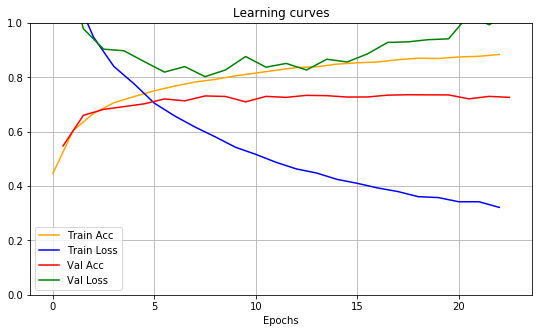

Validation accuracy:  0.736
Test accuracy:  0.7284


In [14]:
#Plotting of learning curves
def plot_history(history):
    plt.figure(figsize=(9,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'], color='blue')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'], color='red')
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'], color='green')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel("Epochs")
    plt.title("Learning curves")
    plt.show() 

plot_history(history)
print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Example images of misclassification:


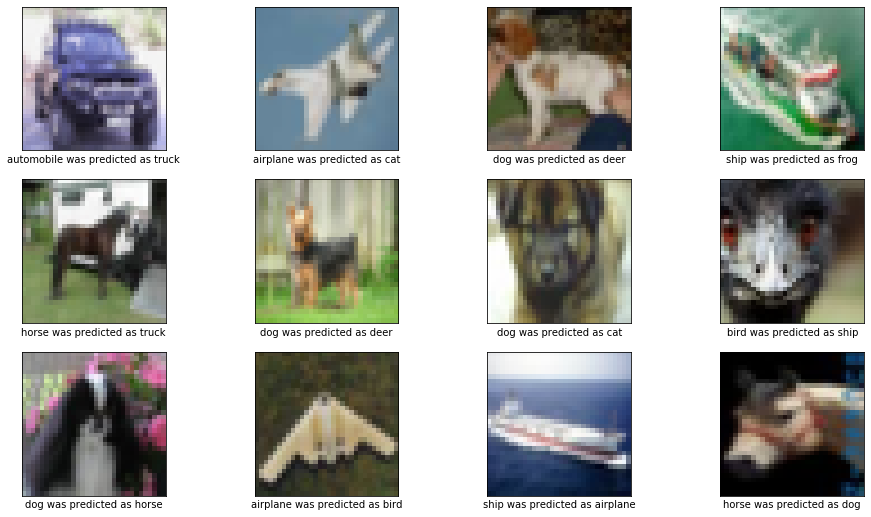

In [15]:
#Showing some misclassifications
y_pred = model.predict_classes(X_test)
mis_counter = 0
print("Example images of misclassification:")
plt.figure(figsize=(16,9))
for i in range(y_pred.size):
    if y_pred[i] != y_test[i]:
        plt.subplot(3,4,mis_counter+1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(label_names[y_test[i]] + " was predicted as " + label_names[y_pred[i]])
        plt.imshow(X_test[i,:,:])
        plt.grid(False)
        mis_counter += 1
        if mis_counter >= 12:
            break
plt.show()